In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import DenseNet201
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import top_k_categorical_accuracy
import math
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import os

Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3552539211147702672
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3282324684
locality {
  bus_id: 1
}
incarnation: 15304982031373490609
physical_device_desc: "device: 0, name: GeForce GTX 950M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [4]:

params = {}
params["train_dir"] = "train"
params["test_dir"] = "test"
params["batch_size"] = 64
params["img_width"] = 221
params["img_height"] = 221
params["train_size"] = sum([len(files) for r, d, files in os.walk( params["train_dir"] )])
params["test_size"] = sum([len(files) for r, d, files in os.walk( params["test_dir"] )])
params["model"] = "ResNet50"
params["classes"] = sum([len(d) for r, d, files in os.walk( params["train_dir"] )])
params["dense_num"] = 2
params["dense1"] = {"num":1024, "dropout":0.1, "pool":"avg_poolx", "activation":"relu"}
params["dense2"] = {"num":params["classes"], "activation":"softmax"}
params["loss"] = "categorical_crossentropy"
params["optimizer"] = "adam"
params["metrics"] = [top_k_categorical_accuracy, 'accuracy']
params["initial_epoch"] = 5
params["final_epoch"] = 10
params["workers"] = 8
params["step_per_epoch"] = 80
params["train_threshold"] = 0
params["phase1_optimizer"] = "adam"
params["phase2_optimizer"] = SGD(lr=0.001, momentum=0.9)

In [5]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        params["train_dir"],
        target_size = (params["img_width"], params["img_height"]),
        batch_size = params["batch_size"],
        shuffle = True,
        class_mode = 'categorical')

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
        params["test_dir"],
        target_size = (params["img_width"], params["img_height"]),
        batch_size = params["batch_size"],
        shuffle = True,
        class_mode = 'categorical')

Found 8187 images belonging to 102 classes.
Found 957 images belonging to 102 classes.


In [6]:
base_model=None
if params["model"] == "InceptionV3":
    params["train_threshold"] = 249
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=None, input_shape=(params["img_width"], params["img_height"], 3))
    print("par" + str(params["img_width"]))
elif params["model"] == "xception":
    params["train_threshold"] = 106
    base_model = Xception(weights='imagenet', include_top=False, input_tensor=None, input_shape=(params["img_width"], params["img_height"], 3))
elif params["model"] == "InceptionResNetV2":
    params["train_threshold"] = 727
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=None, input_shape=(params["img_width"], params["img_height"], 3))
elif params["model"] == "DenseNet121":
    params["train_threshold"] = 403
    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=None, input_shape=(params["img_width"], params["img_height"], 3))    
elif params["model"] == "DenseNet169": 
    params["train_threshold"] = 571
    base_model = DenseNet169(weights='imagenet', include_top=False, input_tensor=None, input_shape=(params["img_width"], params["img_height"], 3))    
elif params["model"] == "DenseNet201":
    params["train_threshold"] = 683
    base_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=None, input_shape=(params["img_width"], params["img_height"], 3))    
elif params["model"] == "ResNet50":
    params["train_threshold"] = 140
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=None, pooling=None, input_shape=(params["img_width"], params["img_height"], 3))    
else:
    print("unknown model")
count = 0
print("entering")
modelx = base_model.output
print(params["dense_num"])

while count < params["dense_num"]:
    count += 1
    string = "dense"+str(count)
    print(string + "string_name")

    if "pool" in params[string]:
        if params[string]["pool"] == "avg_poolx":
            print(string + "pool " + params[string]["pool"])
            modelx = GlobalAveragePooling2D(name=params[string]["pool"])(modelx)
    print(string + "sense " + str(params[string]["num"]))

    modelx = Dense(params[string]["num"], activation = params[string]["activation"])(modelx)
    
    if "dropout" in params[string]:
        print("dropout " + string + str(params[string]["dropout"]))
        modelx = Dropout(params[string]["dropout"])(modelx)
        
model = Model(inputs=base_model.input, output=modelx)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss=params["loss"], optimizer=params["phase1_optimizer"], metrics=params["metrics"])

entering
2
dense1string_name
dense1pool avg_poolx
dense1sense 1024
dropout dense10.1
dense2string_name
dense2sense 102


C:\Users\zxcve\Anaconda3\lib\site-packages\ipykernel\__main__.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [7]:
tbd = TensorBoard(log_dir='./logs_' + params["model"] ,  batch_size=params["batch_size"], write_graph=True )

In [8]:
from keras.utils import plot_model
plot_model(model, to_file=params["model"] + '.png')

In [9]:
history = model.fit_generator(generator=train_generator,
                         steps_per_epoch = params["step_per_epoch"],
                         epochs = params["initial_epoch"],
                         use_multiprocessing=False,
                         max_queue_size=10,
                         workers = params["workers"],     
                         validation_data = validation_generator,
                         callbacks=[tbd ],
                         validation_steps = math.ceil(params["test_size"]  / params["batch_size"]))

Epoch 1/5
80/80 [==============================] - 187s 2s/step - loss: 1.4471 - top_k_categorical_accuracy: 0.8269 - acc: 0.6832 - val_loss: 4.9767 - val_top_k_categorical_accuracy: 0.1358 - val_acc: 0.0418
Epoch 2/5
80/80 [==============================] - 181s 2s/step - loss: 0.4727 - top_k_categorical_accuracy: 0.9695 - acc: 0.8748 - val_loss: 5.6843 - val_top_k_categorical_accuracy: 0.1463 - val_acc: 0.0481
Epoch 3/5
80/80 [==============================] - 180s 2s/step - loss: 0.3184 - top_k_categorical_accuracy: 0.9853 - acc: 0.9024 - val_loss: 5.9232 - val_top_k_categorical_accuracy: 0.0867 - val_acc: 0.0460
Epoch 4/5
80/80 [==============================] - 3523s 44s/step - loss: 0.2190 - top_k_categorical_accuracy: 0.9949 - acc: 0.9330 - val_loss: 6.0664 - val_top_k_categorical_accuracy: 0.1546 - val_acc: 0.0481
Epoch 5/5
80/80 [==============================] - 180s 2s/step - loss: 0.1751 - top_k_categorical_accuracy: 0.9961 - acc: 0.9492 - val_loss: 6.4619 - val_top_k_categ

dict_keys(['val_loss', 'val_top_k_categorical_accuracy', 'val_acc', 'loss', 'top_k_categorical_accuracy', 'acc'])


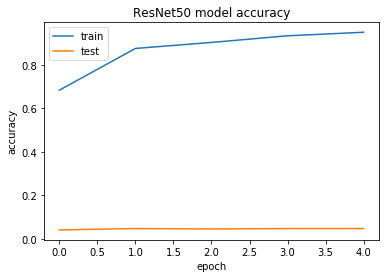

In [10]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title(params["model"] + ' model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

for layer in model.layers[:params["train_threshold"]]:
   layer.trainable = False
for layer in model.layers[params["train_threshold"]:]:
   layer.trainable = True

0 input_1
1 conv1
2 bn_conv1
3 activation_1
4 max_pooling2d_1
5 res2a_branch2a
6 bn2a_branch2a
7 activation_2
8 res2a_branch2b
9 bn2a_branch2b
10 activation_3
11 res2a_branch2c
12 res2a_branch1
13 bn2a_branch2c
14 bn2a_branch1
15 add_1
16 activation_4
17 res2b_branch2a
18 bn2b_branch2a
19 activation_5
20 res2b_branch2b
21 bn2b_branch2b
22 activation_6
23 res2b_branch2c
24 bn2b_branch2c
25 add_2
26 activation_7
27 res2c_branch2a
28 bn2c_branch2a
29 activation_8
30 res2c_branch2b
31 bn2c_branch2b
32 activation_9
33 res2c_branch2c
34 bn2c_branch2c
35 add_3
36 activation_10
37 res3a_branch2a
38 bn3a_branch2a
39 activation_11
40 res3a_branch2b
41 bn3a_branch2b
42 activation_12
43 res3a_branch2c
44 res3a_branch1
45 bn3a_branch2c
46 bn3a_branch1
47 add_4
48 activation_13
49 res3b_branch2a
50 bn3b_branch2a
51 activation_14
52 res3b_branch2b
53 bn3b_branch2b
54 activation_15
55 res3b_branch2c
56 bn3b_branch2c
57 add_5
58 activation_16
59 res3c_branch2a
60 bn3c_branch2a
61 activation_17
62 res3c

In [12]:
model.compile(loss=params["loss"], optimizer=params["phase2_optimizer"], metrics=params["metrics"])

In [13]:
history1 = model.fit_generator(generator=train_generator,
                         steps_per_epoch = params["step_per_epoch"] ,
                         epochs = params["final_epoch"] ,
                         initial_epoch= params["initial_epoch"] ,
                         use_multiprocessing=False,
                         max_queue_size=10,
                         workers = params["workers"],                                  
                         validation_data = validation_generator,
                         callbacks=[tbd],
                         validation_steps = math.ceil(params["test_size"]  / params["batch_size"]))


Epoch 6/10
80/80 [==============================] - 216s 3s/step - loss: 0.0916 - top_k_categorical_accuracy: 0.9996 - acc: 0.9724 - val_loss: 6.8076 - val_top_k_categorical_accuracy: 0.0899 - val_acc: 0.0376
Epoch 7/10
80/80 [==============================] - 211s 3s/step - loss: 0.0575 - top_k_categorical_accuracy: 1.0000 - acc: 0.9830 - val_loss: 6.7685 - val_top_k_categorical_accuracy: 0.0899 - val_acc: 0.0470
Epoch 8/10
80/80 [==============================] - 211s 3s/step - loss: 0.0480 - top_k_categorical_accuracy: 0.9998 - acc: 0.9896 - val_loss: 6.7831 - val_top_k_categorical_accuracy: 0.0899 - val_acc: 0.0449
Epoch 9/10
80/80 [==============================] - 211s 3s/step - loss: 0.0366 - top_k_categorical_accuracy: 0.9998 - acc: 0.9914 - val_loss: 6.7416 - val_top_k_categorical_accuracy: 0.0899 - val_acc: 0.0449
Epoch 10/10
80/80 [==============================] - 211s 3s/step - loss: 0.0376 - top_k_categorical_accuracy: 1.0000 - acc: 0.9916 - val_loss: 6.8074 - val_top_k_c

In [14]:
model.save_weights("model_" + params["model"] + ".h5")

dict_keys(['val_loss', 'val_top_k_categorical_accuracy', 'val_acc', 'loss', 'top_k_categorical_accuracy', 'acc'])


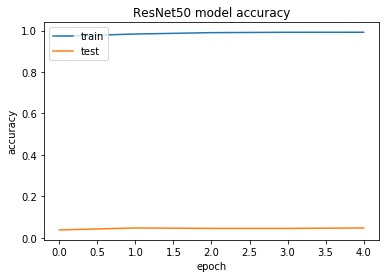

In [15]:
print(history1.history.keys())
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title(params["model"] + ' model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
import pickle
with open(params["model"] + ".history0", "wb") as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
with open(params["model"] + ".history1", "wb") as f:
    pickle.dump(history1.history, f, pickle.HIGHEST_PROTOCOL)